## Nguyễn Thành Danh - Differential Evolution (DE) & (1+λ)-Evolution Strategies (ES)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# 240201008
STUDENT_ID = 1008

### Objective Functions

In [2]:
def sphere(z):
    """Sphere function: f(z) = sum(z_i^2). Accepts lists or numpy arrays."""
    z = np.asarray(z)
    return float(np.sum(z**2))


In [3]:
def ackley(z, a=20, b=0.2, c=2*np.pi):
    z = np.asarray(z)
    n = z.size

    sum1 = np.mean(z**2)
    sum2 = np.mean(np.cos(c * z))

    term1 = -a * np.exp(-b * np.sqrt(sum1))
    term2 = -np.exp(sum2)
    return float(term1 + term2 + a + np.e)

In [4]:
def griewank(z):
    z = np.asarray(z)
    sum_ = np.sum(z**2) / 4000.0
    idx = np.arange(1, z.size + 1)
    prod_ = np.prod(np.cos(z / np.sqrt(idx)))
    return float(1.0 + sum_ - prod_)

In [5]:
def rosenbrock(z):
    z = np.asarray(z, dtype=float)
    if z.size < 2:
        return 0.0
    xi = z[:-1]
    xi1 = z[1:]
    return float(np.sum(100.0 * (xi1 - xi**2)**2 + (xi - 1.0)**2))

In [6]:

def michalewicz(z, m=10):
    z = np.asarray(z, dtype=float)
    if z.size == 0:
        return 0.0
    idx = np.arange(1, z.size + 1)
    return float(-np.sum(np.sin(z) * (np.sin(idx * z**2 / np.pi) ** (2 * m))))

### Differential Evolution (DE)

In [7]:
def de(fobj, bounds, F_scale=0.8, cross_prob=0.7, popsize=20, max_evals=2000):
    dimensions = len(bounds); lower_bound, upper_bound = np.asarray(bounds).T

    diff = np.fabs(lower_bound - upper_bound)

    pop = lower_bound + diff * np.random.rand(popsize, dimensions)

    fitness = np.asarray([fobj(ind) for ind in pop])
    eval_count = popsize
    should_break = False

    best_idx = np.argmin(fitness)

    best = pop[best_idx]

    results = []; all_pops = []
    results.append((np.copy(best), fitness[best_idx]))
    all_pops.append(np.copy(pop))
    while eval_count < max_evals:
        for j in range(popsize):
            if eval_count >= max_evals:
                should_break = True
                break

            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + F_scale * (b-c), lower_bound, upper_bound)

            cross_points = np.random.rand(dimensions) < cross_prob
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True

            trial = np.where(cross_points, mutant, pop[j])

            f = fobj(trial)
            eval_count += 1

            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial

        if should_break:
            break
        results.append((np.copy(best), fitness[best_idx]))
        all_pops.append(np.copy(pop))


    return results, all_pops


### Differential Evolution (DE)

In [8]:
def es(fobj, bounds, sigma_init=1.0, c_inc=1.1, c_dec=0.6, popsize=20, max_evals=2000):
    dimensions = len(bounds)

    lower_bound, upper_bound = np.asarray(bounds).T

    diff = np.fabs(lower_bound - upper_bound)

    mu = lower_bound + diff * np.random.rand(dimensions)

    mu_fitness = fobj(mu)
    eval_count = 1
    should_break = False

    results = []
    all_pops = []
    results.append((np.copy(mu), mu_fitness))
    sigma = sigma_init

    while eval_count < max_evals:
        epsilon = np.random.randn(popsize, dimensions)
        offspring = mu + sigma * epsilon
        offspring = np.clip(offspring, lower_bound, upper_bound)
        offspring_fitness = []
        for i in range(popsize):
            if eval_count >= max_evals:
                should_break = True
                break
            fitness = fobj(offspring[i])
            offspring_fitness.append(fitness)
            eval_count += 1
            
        if should_break:
            break
            
        offspring_fitness = np.array(offspring_fitness)
        best_idx = offspring_fitness.argmin()
        best_fitness = offspring_fitness[best_idx]
        best_offspring = offspring[best_idx]

        if best_fitness <= mu_fitness:
            mu = best_offspring.copy()
            mu_fitness = best_fitness
            sigma *= c_inc
        else:
            sigma *= c_dec

        results.append((np.copy(mu), mu_fitness))
        all_pops.append(np.copy(offspring))

    return results, all_pops

### Factory Functions

In [ ]:
def get_bounds(func_name, dim):
    bounds_dict = {
        'sphere': [(-5.12, 5.12)] * dim,
        'ackley': [(-32.768, 32.768)] * dim,
        'griewank': [(-600, 600)] * dim,
        'rosenbrock': [(-5, 10)] * dim,
        'michalewicz': [(0, np.pi)] * dim
    }
    
    return bounds_dict[func_name]

def get_function(func_name):
    func_dict = {
        'sphere': sphere,
        'ackley': ackley,
        'griewank': griewank,
        'rosenbrock': rosenbrock,
        'michalewicz': michalewicz
    }
    
    return func_dict[func_name]

def run_experiment(func_name, dim, algorithm):
    # Set parameters based on dimension
    func = get_function(func_name)
    bounds = get_bounds(func_name, dim)
    popsize = 10 if dim == 2 else 100
    max_evals = 2000 if dim == 2 else 20000

    # Run 10 independent runs with different seeds based on student number
    seeds = list(range(STUDENT_ID, STUDENT_ID + 10))
    all_results = []
    for seed in seeds:
        np.random.seed(seed)
        
        if algorithm == 'DE':
            results, all_pops = de(func, bounds=bounds, popsize=popsize, max_evals=max_evals)
        else:
            results, all_pops = es(func, bounds=bounds, popsize=popsize, max_evals=max_evals)
        
        fitness_per_gen = [result[1] for result in results]
        all_results.append(fitness_per_gen)
    
    return all_results


### Analyze Functions

In [16]:
def plot_and_analyze(func_name, dim):
    print("Running...")
    de_results = run_experiment(func_name, dim, 'DE')
    es_results = run_experiment(func_name, dim, 'ES')
    
    de_mean = np.mean(de_results, axis=0)
    de_std = np.std(de_results, axis=0)
    es_mean = np.mean(es_results, axis=0)
    es_std = np.std(es_results, axis=0)
    
    # Create generations axis
    generations = range(len(de_mean))
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    plt.plot(generations, de_mean, 'b-', label='DE', linewidth=2)
    plt.fill_between(generations, de_mean - de_std, de_mean + de_std, 
                     alpha=0.2, color='blue')
    plt.plot(generations, es_mean, 'r-', label='ES', linewidth=2)
    plt.fill_between(generations, es_mean - es_std, es_mean + es_std, 
                     alpha=0.2, color='red')
    
    # Formatting
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title(f'{func_name.title()} Function (d={dim})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if func_name in ['sphere', 'ackley', 'griewank', 'rosenbrock']:
        plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # ===== SUMMARY TABLE =====
    # Get final fitness values (last generation)
    de_final = [run[-1] for run in de_results]
    es_final = [run[-1] for run in es_results]
    
    # Calculate final statistics
    de_final_mean = np.mean(de_final)
    de_final_std = np.std(de_final)
    es_final_mean = np.mean(es_final)
    es_final_std = np.std(es_final)
    
    return {
        'function': func_name,
        'dimension': dim,
        'DE_mean': de_final_mean,
        'DE_std': de_final_std,
        'ES_mean': es_final_mean,
        'ES_std': es_final_std,
        'de_results': de_results,
        'es_results': es_results
    }

def run_all_experiments():
    """Run all experiments efficiently - once per function/dimension"""
    
    functions = ['sphere', 'ackley', 'griewank', 'rosenbrock', 'michalewicz']
    dimensions = [2, 10]
    
    all_summaries = []
    
    for func in functions:
        for dim in dimensions:
            summary = plot_and_analyze(func, dim)
            all_summaries.append(summary)
    
    # Create final comparison table
    print("\n" + "="*70)
    print("FINAL COMPARISON TABLE")
    print("="*70)
    print(f"{'Function':<12} {'Dim':<4} {'DE Mean':<12} {'DE Std':<12} {'ES Mean':<12} {'ES Std':<12} {'Winner':<8}")
    print("-"*70)
    
    for summary in all_summaries:
        # Determine winner based on mean fitness (lower is better)
        if summary['DE_mean'] < summary['ES_mean']:
            winner = "DE"
        elif summary['ES_mean'] < summary['DE_mean']:
            winner = "ES"
        else:
            winner = "Tie"
        
        print(f"{summary['function']:<12} {summary['dimension']:<4} "
              f"{summary['DE_mean']:<12.7f} {summary['DE_std']:<12.7f} "
              f"{summary['ES_mean']:<12.7f} {summary['ES_std']:<12.7f} "
              f"{winner:<8}")
    
    return all_summaries

Running...


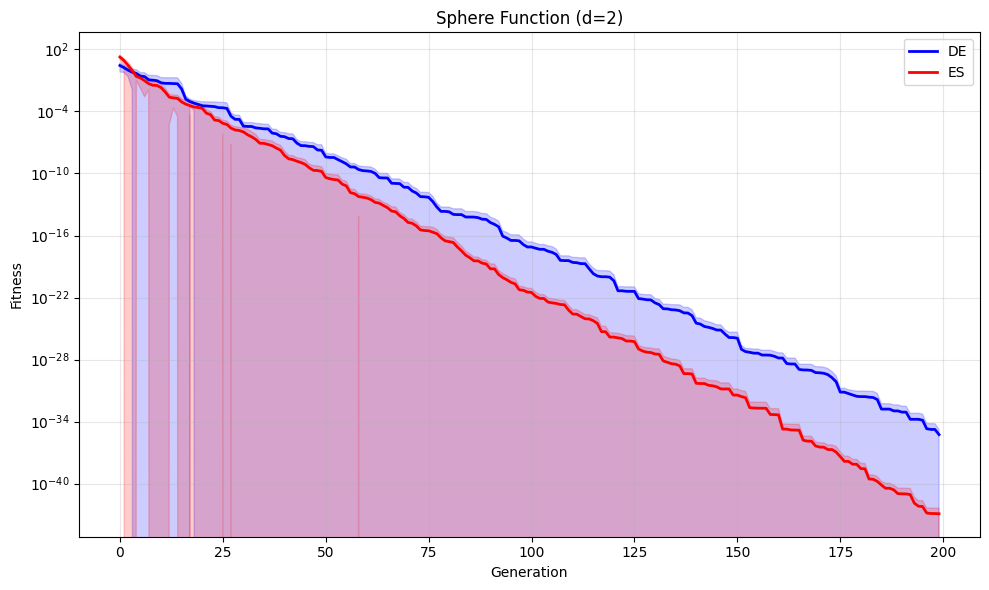

Running...


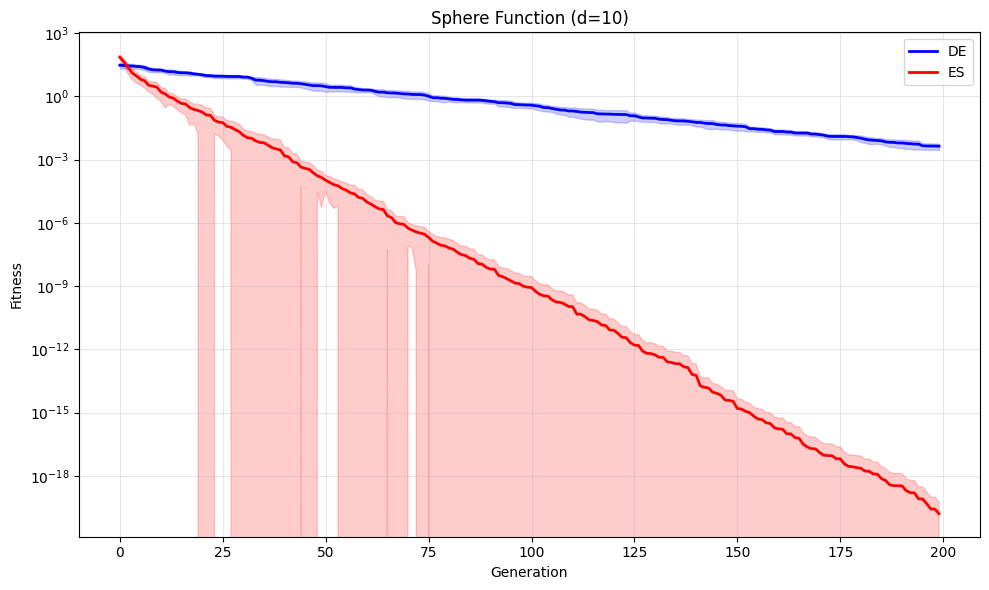

Running...


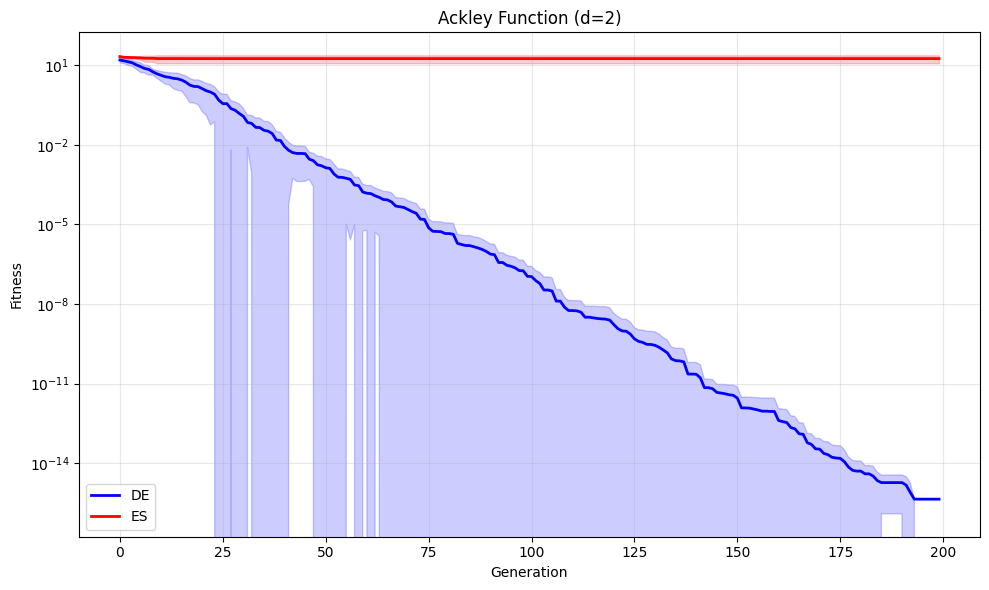

Running...


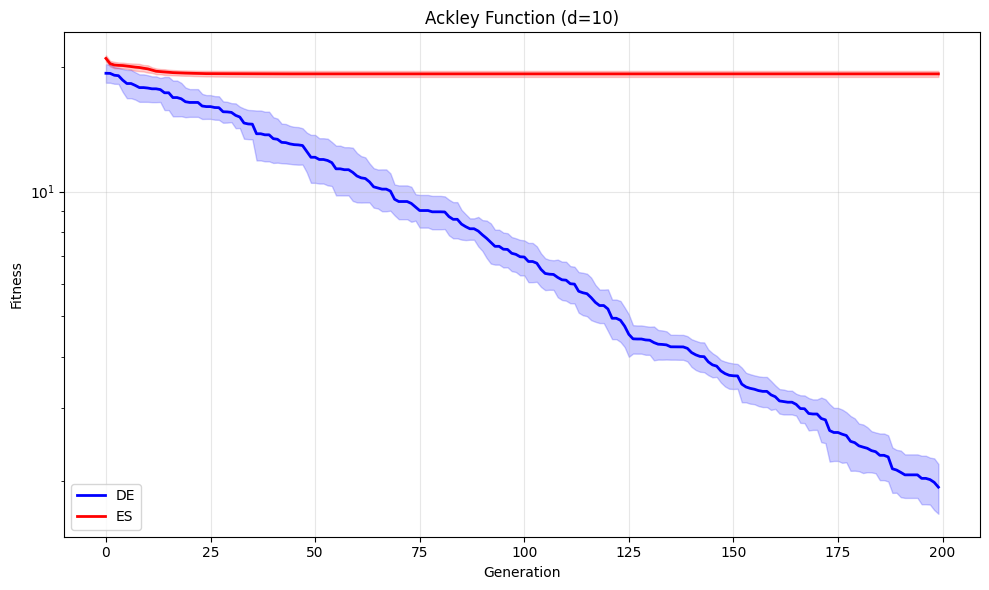

Running...


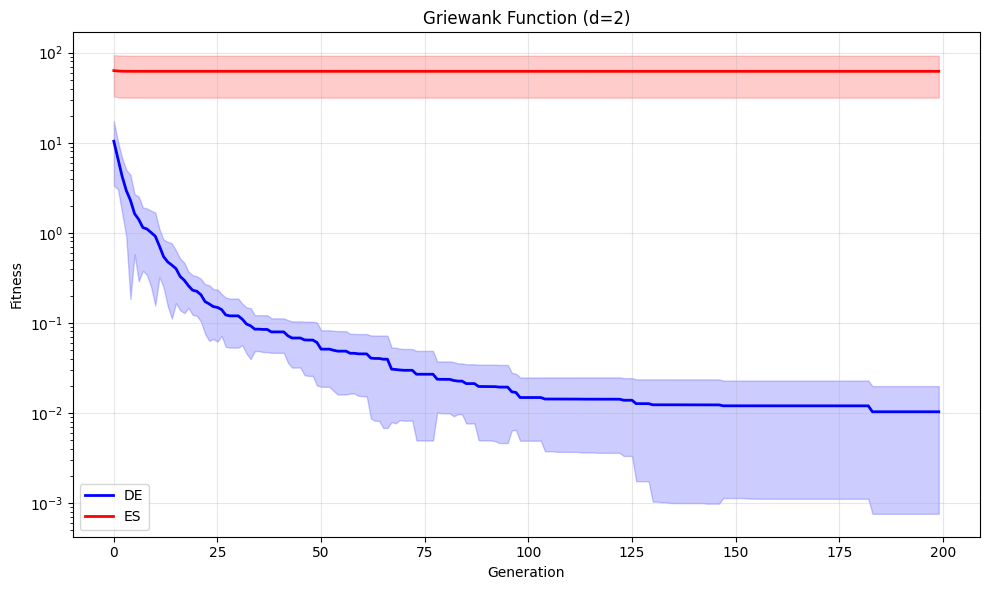

Running...


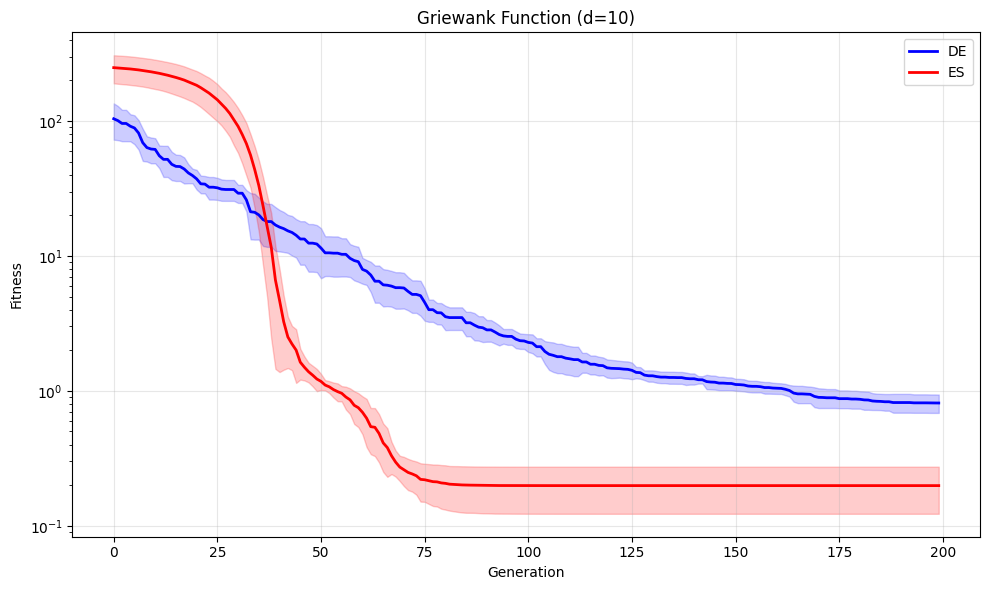

Running...


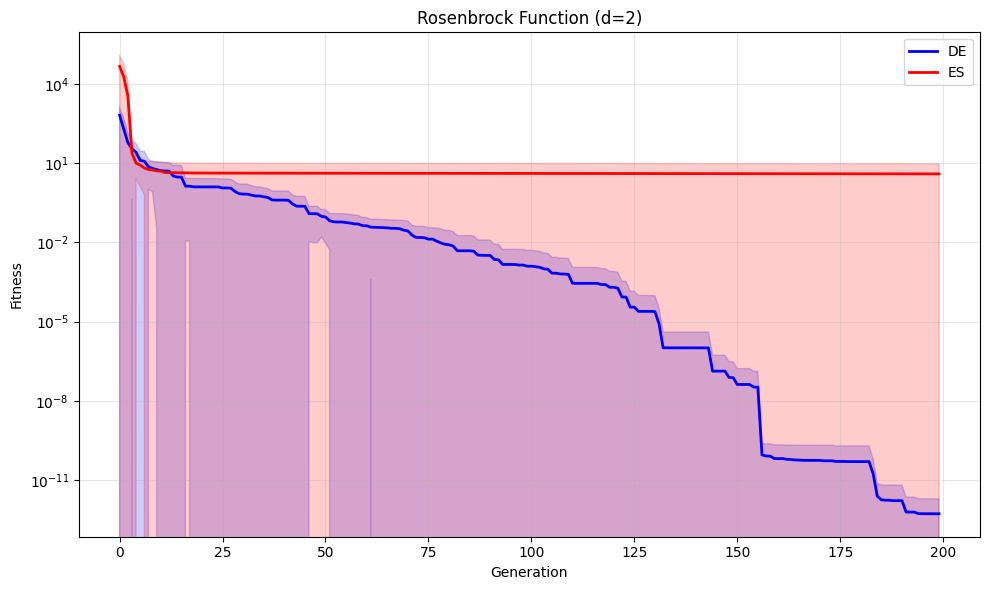

Running...


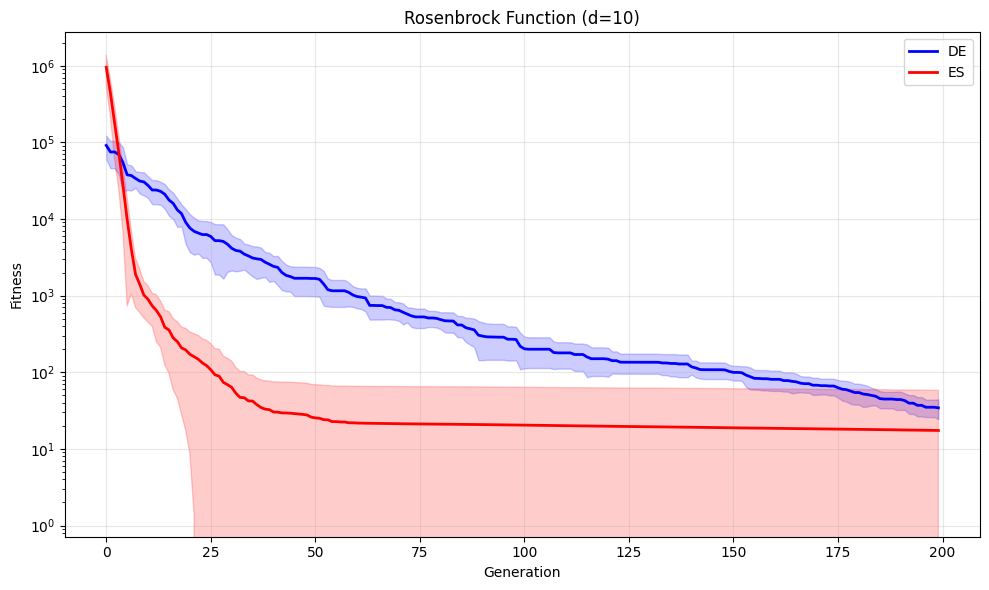

Running...


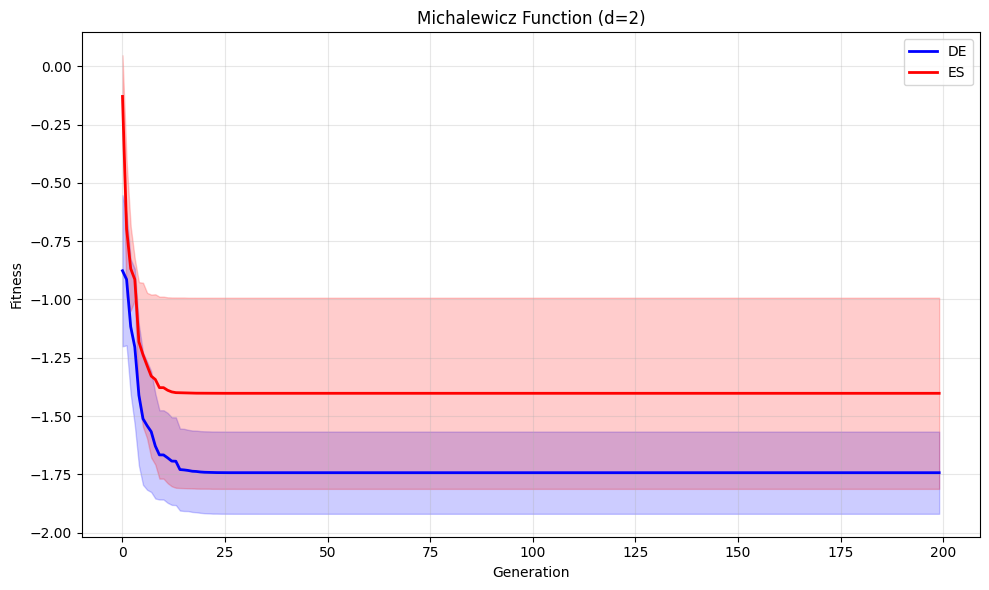

Running...


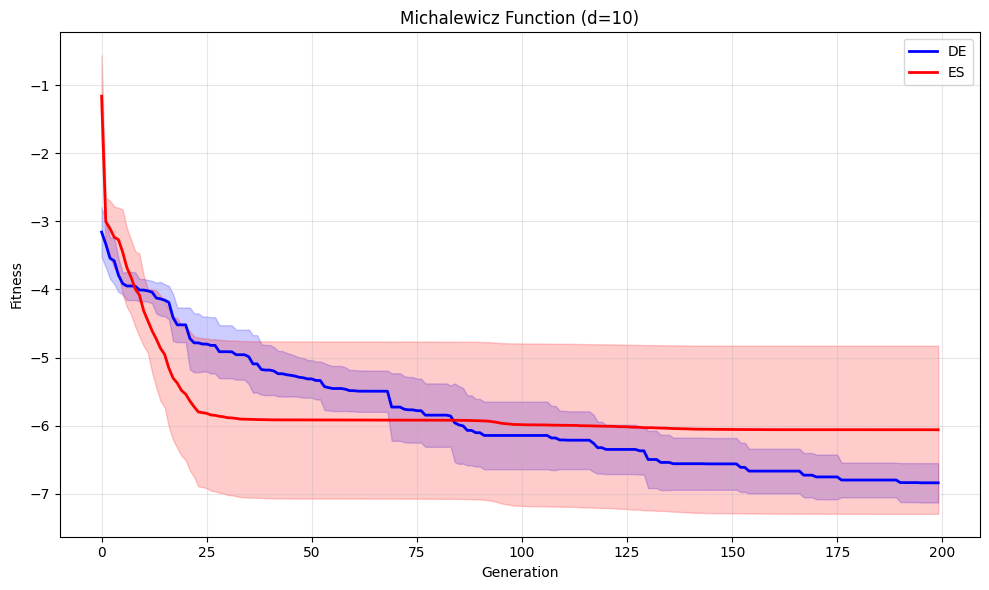


FINAL COMPARISON TABLE
Function     Dim  DE Mean      DE Std       ES Mean      ES Std       Winner  
----------------------------------------------------------------------
sphere       2    0.0000000    0.0000000    0.0000000    0.0000000    ES      
sphere       10   0.0043458    0.0014410    0.0000000    0.0000000    ES      
ackley       2    0.0000000    0.0000000    17.5670376   5.8609295    DE      
ackley       10   1.9376845    0.2667424    19.2405110   0.3214814    DE      
griewank     2    0.0102665    0.0095113    62.0718555   30.4112418   DE      
griewank     10   0.8122086    0.1265904    0.1982894    0.0757077    ES      
rosenbrock   2    0.0000000    0.0000000    3.9467389    5.5398097    DE      
rosenbrock   10   34.3585002   9.8951801    17.4031577   40.7110770   ES      
michalewicz  2    -1.7425790   0.1761732    -1.4021880   0.4096567    DE      
michalewicz  10   -6.8391826   0.2889953    -6.0600907   1.2339292    DE      


In [17]:
# Run ALL experiments efficiently
all_results = run_all_experiments()

### Nhận xét

**Quan sát:**
- **Hàm Sphere**: $\text{ES}$ cho kết quả tốt hơn $\text{DE}$. Hàm lồi và trơn (dạng bát úp lý tưởng). $\text{DE}$ không có lợi thế về tính đa dạng vì chỉ cần khai thác cục bộ. $\text{ES}$ với cơ chế tự điều chỉnh kích thước bước ($\sigma$) hoạt động tương tự như $\text{Gradient Descent}$ trong không gian đã biến đổi, cho phép nó tiến thẳng đến cực tiểu nhanh và chính xác hơn so với $\text{DE}$ trên các hàm đơn giản này.
- **Hàm Ackley**: DE vượt trội rõ rệt so với ES trên cả dim=2 và dim=10. Ackley là hàm đa cực tiểu (multimodal) với nhiều bẫy cục bộ. $\text{DE}$ mạnh về khám phá toàn cục (Global Exploration) nhờ toán tử đột biến dựa trên Differential Vector, giúp duy trì đa dạng quần thể và dễ dàng thoát khỏi các cực tiểu cục bộ. $\text{ES}$ sinh mẫu tập trung quanh điểm trung tâm, khiến nó dễ bị kẹt trong bẫy hơn..
- **Hàm Griewank**: ở dim=2, uu thế khám phá của $\text{DE}$ phát huy tác dụng trong không gian tìm kiếm nhỏ. Tuy nhiên ở dim=10, đột biến vectơ sai khác của $\text{DE}$ trở nên ngẫu nhiên và kém hiệu quả (gây nhiễu), làm giảm khả năng khai thác. $\text{ES}$ duy trì sự ổn định và hiệu quả hơn nhờ cơ chế tự điều chỉnh $\sigma$ liên tục..
- **Hàm Rosenbrock**: ở dim=2, $\text{DE}$ đủ linh hoạt để di chuyển trong thung lũng không quá khắc nghiệt. $\text{ES}$ cơ bản khó bẻ hướng theo đường cong. Tuy nhiên, ở không gian cao hơn, DE kém ổn định hơn nhiều do các vector khác biệt có xu hướng toả ra nhiều hướng, giảm hiệu quả tìm kiếm. Trong khi đó ES duy trì sự ổn định nhờ cơ chế tự điều chỉnh sigma.
- **Hàm Michalewicz**: tương tự như hàm Ackley, đây là hàm bẫy có nhiều cực tiểu cục bộ, do đó DE với ưu điểm về tính đa dạng dễ dàng vượt trội SE.

**Tổng kết:**
- DE mạnh về Khám phá Toàn cục (Global Exploration): Lý tưởng cho các hàm đa cực tiểu (multimodal) và có địa hình gồ ghề (như Ackley, Michalewicz).

- ES mạnh về Khai thác Cục bộ (Local Exploitation): Lý tưởng cho các hàm trơn, đơn cực tiểu (unimodal) và đặc biệt xuất sắc khi xử lý các vấn đề không tách được (non-separable) và điều kiện kém (ill-conditioned) ở chiều cao (như Rosenbrock dim 10 và Sphere).